#Library Import

First we need to import all libraries needed for the project

In [1]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 20 kB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier, plot_importance

#Load and Explore Data

In [3]:
df = pd.read_csv('nasa.csv')

In [4]:
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [5]:
df.corr('spearman')

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
Neo Reference ID,1.000000,1.000000,0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,0.237549,-0.138405,-0.138405,-0.138405,-0.106017,-0.106017,-0.106017,-0.106017,-0.654794,0.576262,-0.154896,0.015572,-0.005565,-0.121150,-0.000508,-0.159315,-0.018724,-0.000508,0.096537,-0.003189,-0.047632,-0.027356,-0.063725,0.000508,-0.240959
Name,1.000000,1.000000,0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,-0.547038,0.237549,-0.138405,-0.138405,-0.138405,-0.106017,-0.106017,-0.106017,-0.106017,-0.654794,0.576262,-0.154896,0.015572,-0.005565,-0.121150,-0.000508,-0.159315,-0.018724,-0.000508,0.096537,-0.003189,-0.047632,-0.027356,-0.063725,0.000508,-0.240959
Absolute Magnitude,0.547038,0.547038,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.176486,-0.380674,-0.380674,-0.380674,-0.346198,-0.346198,-0.346198,-0.346198,-0.756015,0.695608,-0.552259,0.258900,-0.137245,-0.366427,-0.225162,-0.484117,-0.009304,-0.225162,0.081115,0.035346,-0.314262,-0.094909,-0.050905,0.225162,-0.340136
Est Dia in KM(min),-0.547038,-0.547038,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.176486,0.380674,0.380674,0.380674,0.346198,0.346198,0.346198,0.346198,0.756015,-0.695608,0.552259,-0.258900,0.137245,0.366427,0.225162,0.484117,0.009304,0.225162,-0.081115,-0.035346,0.314262,0.094909,0.050905,-0.225162,0.340136
Est Dia in KM(max),-0.547038,-0.547038,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.176486,0.380674,0.380674,0.380674,0.346198,0.346198,0.346198,0.346198,0.756015,-0.695608,0.552259,-0.258900,0.137245,0.366427,0.225162,0.484117,0.009304,0.225162,-0.081115,-0.035346,0.314262,0.094909,0.050905,-0.225162,0.340136
Est Dia in M(min),-0.547038,-0.547038,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.176486,0.380674,0.380674,0.380674,0.346198,0.346198,0.346198,0.346198,0.756015,-0.695608,0.552259,-0.258900,0.137245,0.366427,0.225162,0.484117,0.009304,0.225162,-0.081115,-0.035346,0.314262,0.094909,0.050905,-0.225162,0.340136
Est Dia in M(max),-0.547038,-0.547038,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.176486,0.380674,0.380674,0.380674,0.346198,0.346198,0.346198,0.346198,0.756015,-0.695608,0.552259,-0.258900,0.137245,0.366427,0.225162,0.484117,0.009304,0.225162,-0.081115,-0.035346,0.314262,0.094909,0.050905,-0.225162,0.340136
Est Dia in Miles(min),-0.547038,-0.547038,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.176486,0.380674,0.380674,0.380674,0.346198,0.346198,0.346198,0.346198,0.756015,-0.695608,0.552259,-0.258900,0.137245,0.366427,0.225162,0.484117,0.009304,0.225162,-0.081115,-0.035346,0.314262,0.094909,0.050905,-0.225162,0.340136
Est Dia in Miles(max),-0.547038,-0.547038,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.176486,0.380674,0.380674,0.380674,0.346198,0.346198,0.346198,0.346198,0.756015,-0.695608,0.552259,-0.258900,0.137245,0.366427,0.225162,0.484117,0.009304,0.225162,-0.081115,-0.035346,0.314262,0.094909,0.050905,-0.225162,0.340136
Est Dia in Feet(min),-0.547038,-0.547038,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.176

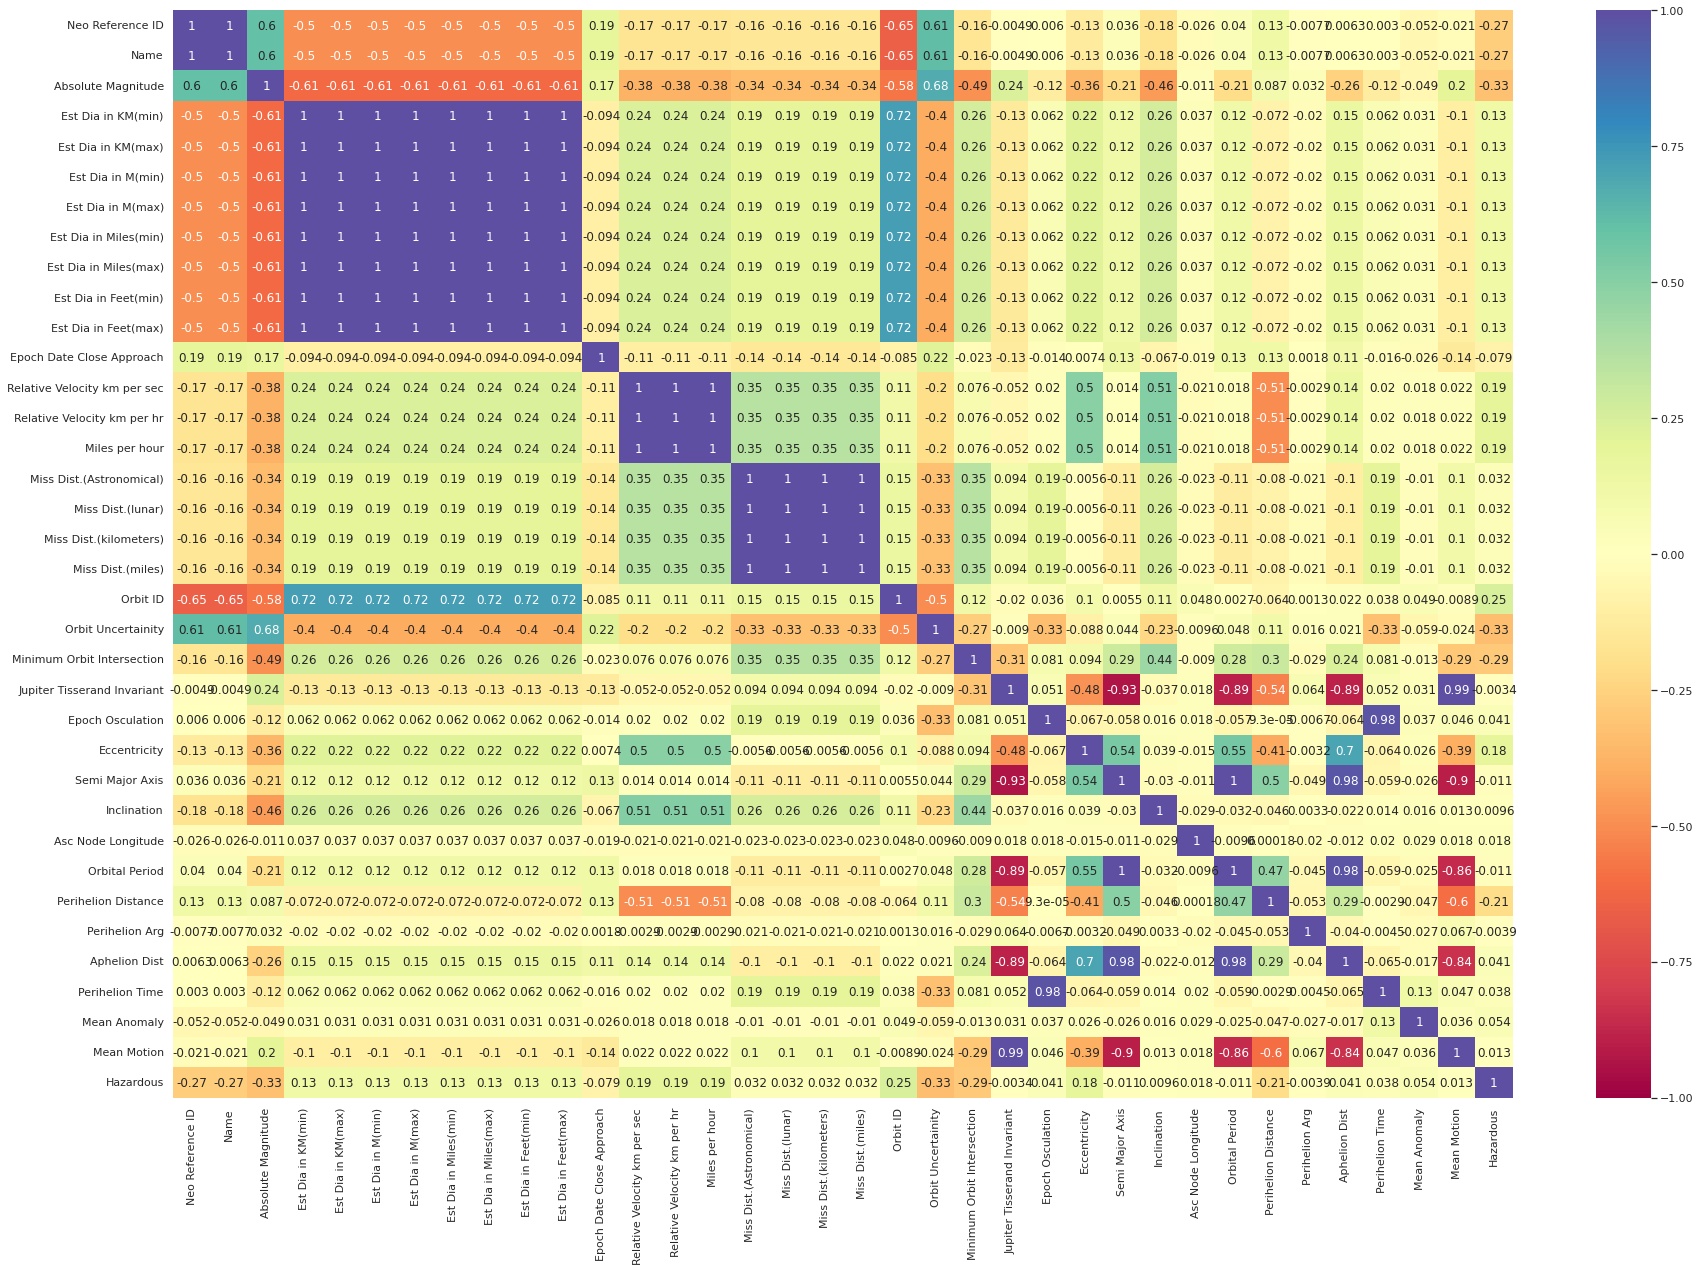

In [6]:
sns.set(rc={'figure.figsize':(30,20)})
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="Spectral", annot=True)
plt.show()
plt.close()

In [7]:
drop_col = ['Neo Reference ID', 'Name', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date', 'Relative Velocity km per hr', 'Miles per hour', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbiting Body', 'Orbit ID', 'Orbit Determination Date', 'Equinox']
drop_col_cat = ['Neo Reference ID', 'Name', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Close Approach Date', 'Relative Velocity km per hr', 'Miles per hour', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Orbit ID', 'Orbit Determination Date']
target_col = ['Hazardous']

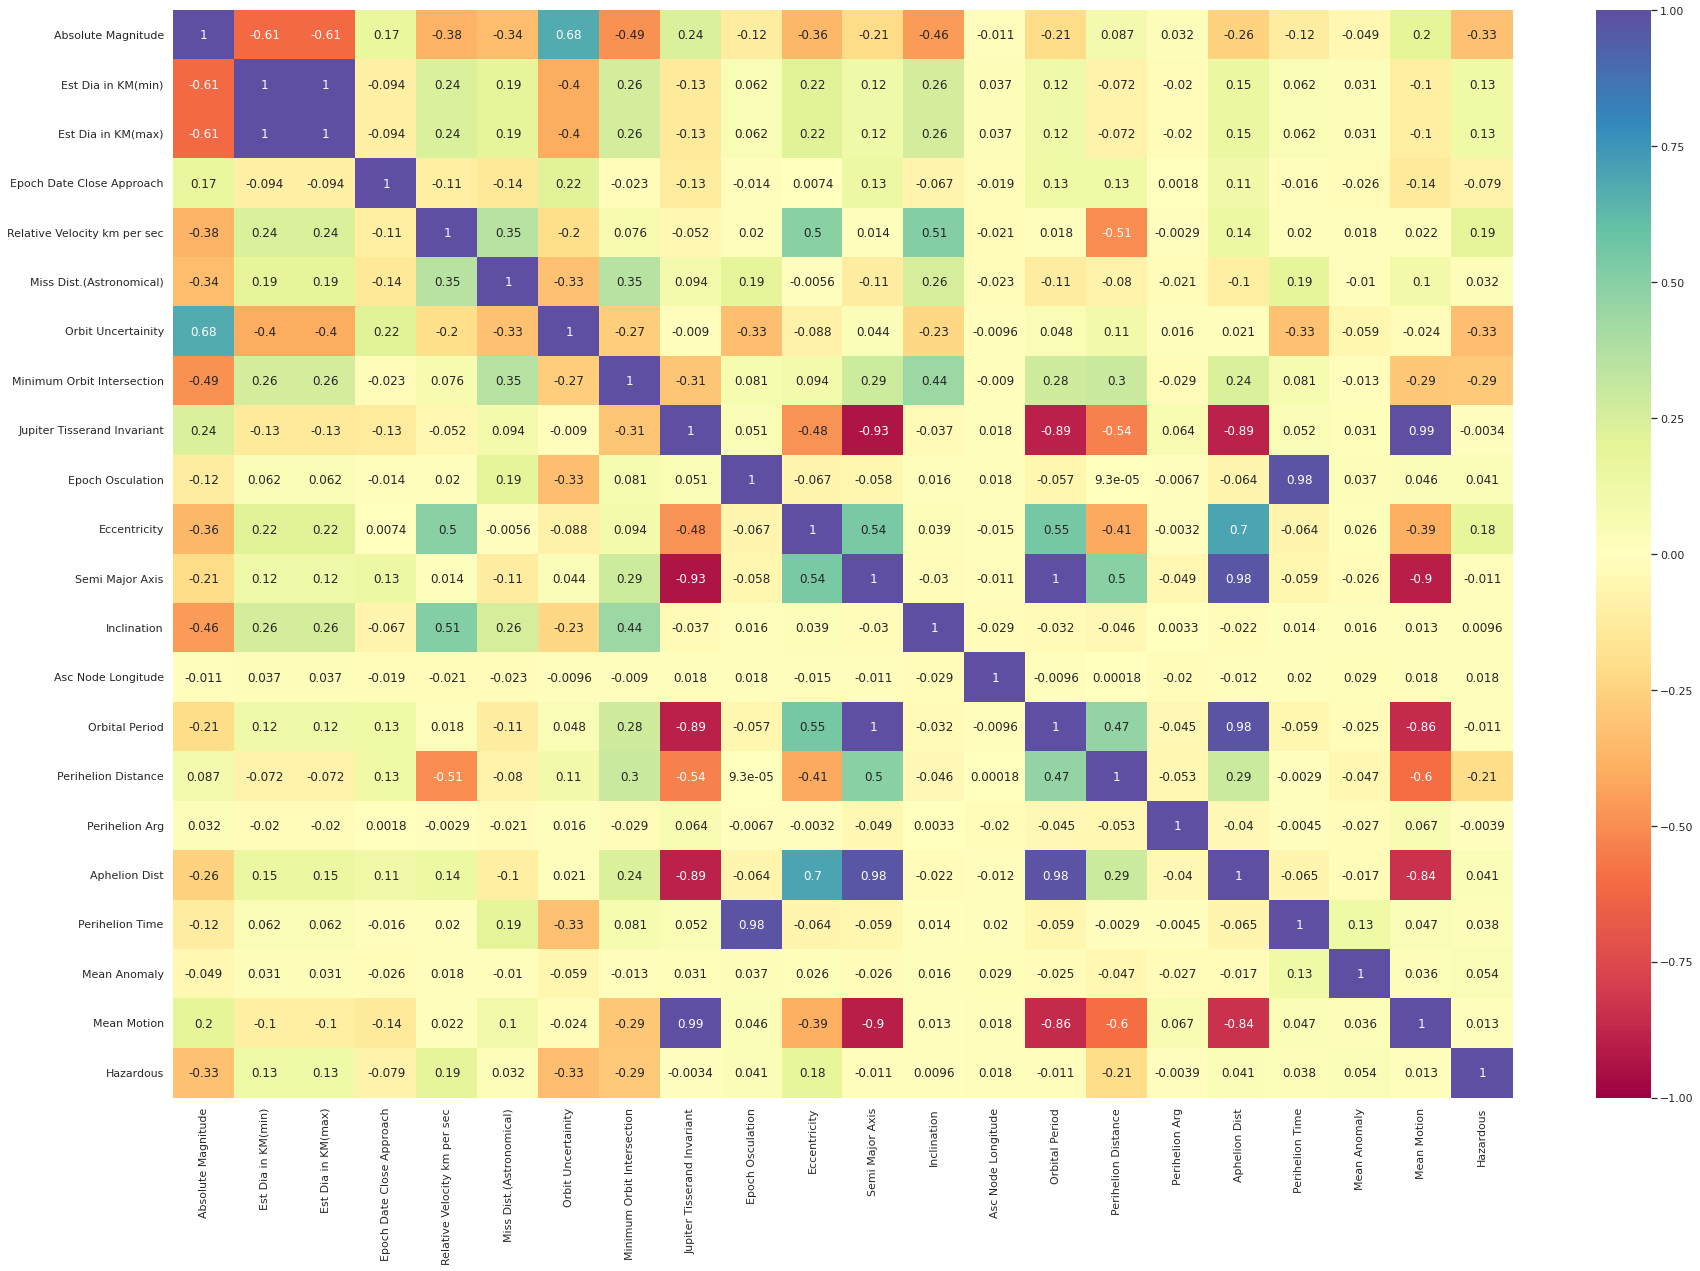

In [8]:
# Dropping completely correlated features and datetime features
df_num = df.drop(drop_col, axis=1)
df_num_cat = df.drop(drop_col_cat, axis=1)

# Plotting feature correlation with reduced dataset
sns.set(rc={'figure.figsize':(30,20)})
sns.heatmap(df_num.corr(), vmin=-1, vmax=1, cmap="Spectral", annot=True)
plt.show()
plt.close()

In [9]:
df_num.isnull().sum()

Absolute Magnitude              0
Est Dia in KM(min)              0
Est Dia in KM(max)              0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Miss Dist.(Astronomical)        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis                 0
Inclination                     0
Asc Node Longitude              0
Orbital Period                  0
Perihelion Distance             0
Perihelion Arg                  0
Aphelion Dist                   0
Perihelion Time                 0
Mean Anomaly                    0
Mean Motion                     0
Hazardous                       0
dtype: int64

In [10]:
df_num_cat.dtypes

Absolute Magnitude              float64
Est Dia in KM(min)              float64
Est Dia in KM(max)              float64
Epoch Date Close Approach         int64
Relative Velocity km per sec    float64
Miss Dist.(Astronomical)        float64
Orbiting Body                    object
Orbit Uncertainity                int64
Minimum Orbit Intersection      float64
Jupiter Tisserand Invariant     float64
Epoch Osculation                float64
Eccentricity                    float64
Semi Major Axis                 float64
Inclination                     float64
Asc Node Longitude              float64
Orbital Period                  float64
Perihelion Distance             float64
Perihelion Arg                  float64
Aphelion Dist                   float64
Perihelion Time                 float64
Mean Anomaly                    float64
Mean Motion                     float64
Equinox                          object
Hazardous                          bool
dtype: object

#Methods

##CatBoost

The data uses all-numerical + categorical features




In [11]:
X = df_num_cat.drop(target_col, axis=1)
y = df[['Hazardous']]

categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

Initialize CatBoost Classifier

In [12]:
clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.1
)

clf.fit(X_train, y_train,
        eval_set=(X_test, y_test), 
        verbose=False,
        cat_features=categorical_features_indices
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 100, 'learning_rate': 0.1}


In [13]:
y_pred_ctb = clf.predict(X_test)
y_test_arr = np.array([str(row['Hazardous']) for index, row in y_test.iterrows()])

acc_ctb = accuracy_score(y_test_arr, y_pred_ctb)

y_test_arr_asfloat = [float(1) if x == 'True' else float(0) for x in y_test_arr]
y_pred_ctb_asfloat = [float(1) if x == 'True' else float(0) for x in y_pred_ctb]
roc_acu_ctb = roc_auc_score(y_test_arr_asfloat, y_pred_ctb_asfloat)

print('Accuracy: '+str(np.round(acc_ctb*100, 2))+'%')
print('ROC-AUC Score: '+str(np.round(roc_acu_ctb*100, 2))+'%')

Accuracy: 99.25%
ROC-AUC Score: 98.13%


In [14]:
confusion_matrix(y_test_arr, y_pred_ctb)

array([[771,   1],
       [  6, 160]])

In [15]:
ctb_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
df_fi = pd.DataFrame({'feature_importance': clf.get_feature_importance(ctb_pool), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], ascending=False)
df_fi

,feature_importance,feature_names
8,58.743207,Minimum Orbit Intersection
1,19.561477,Est Dia in KM(min)
0,14.964997,Absolute Magnitude
2,1.737732,Est Dia in KM(max)
7,1.080704,Orbit Uncertainity
16,0.583519,Perihelion Distance
9,0.519655,Jupiter Tisserand Invariant
21,0.428550,Mean Motion
20,0.394605,Mean Anomaly
15,0.342853,Orbital Period


##CatBoost Without Categorical Features

The data uses only numerical features

In [16]:
X = df_num.drop(target_col, axis=1)
y = df[['Hazardous']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

Initialize CatBoost Classifier

In [17]:
clf = CatBoostClassifier(
    iterations=100, 
    learning_rate=0.1
)

clf.fit(X_train, y_train,
        eval_set=(X_test, y_test), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 100, 'learning_rate': 0.1}


In [18]:
y_pred_ctb = clf.predict(X_test)
y_test_arr = np.array([str(row['Hazardous']) for index, row in y_test.iterrows()])

acc_ctb = accuracy_score(y_test_arr, y_pred_ctb)

y_test_arr_asfloat = [float(1) if x == 'True' else float(0) for x in y_test_arr]
y_pred_ctb_asfloat = [float(1) if x == 'True' else float(0) for x in y_pred_ctb]
roc_acu_ctb = roc_auc_score(y_test_arr_asfloat, y_pred_ctb_asfloat)

print('Accuracy: '+str(np.round(acc_ctb*100, 2))+'%')
print('ROC-AUC Score: '+str(np.round(roc_acu_ctb*100, 2))+'%')

Accuracy: 99.47%
ROC-AUC Score: 98.73%


In [19]:
confusion_matrix(y_test_arr, y_pred_ctb)

array([[771,   1],
       [  4, 162]])

In [20]:
ctb_pool = Pool(X_train, y_train)
df_fi = pd.DataFrame({'feature_importance': clf.get_feature_importance(ctb_pool), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], ascending=False)
df_fi

,feature_importance,feature_names
7,56.324864,Minimum Orbit Intersection
2,16.697370,Est Dia in KM(max)
1,14.236994,Est Dia in KM(min)
0,2.343513,Absolute Magnitude
6,1.183276,Orbit Uncertainity
3,1.109688,Epoch Date Close Approach
19,0.982829,Mean Anomaly
17,0.969257,Aphelion Dist
13,0.691155,Asc Node Longitude
18,0.688051,Perihelion Time


##XGBoost

The data uses only numerical features

In [21]:
X = df_num.drop(target_col, axis=1)
y = df[['Hazardous']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

Initialize XGBoost Classifier

In [22]:
xbg_model = XGBClassifier()
xbg_model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [23]:
y_pred_xgb = xbg_model.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
roc_acu_xgb = roc_auc_score(y_test, y_pred_xgb)

print('Accuracy: '+str(np.round(acc_xgb*100, 2))+'%')
print('ROC-AUC Score: '+str(np.round(roc_acu_xgb*100, 2))+'%')

Accuracy: 99.04%
ROC-AUC Score: 98.0%


In [24]:
confusion_matrix(y_test, y_pred_xgb)

array([[769,   3],
       [  6, 160]])

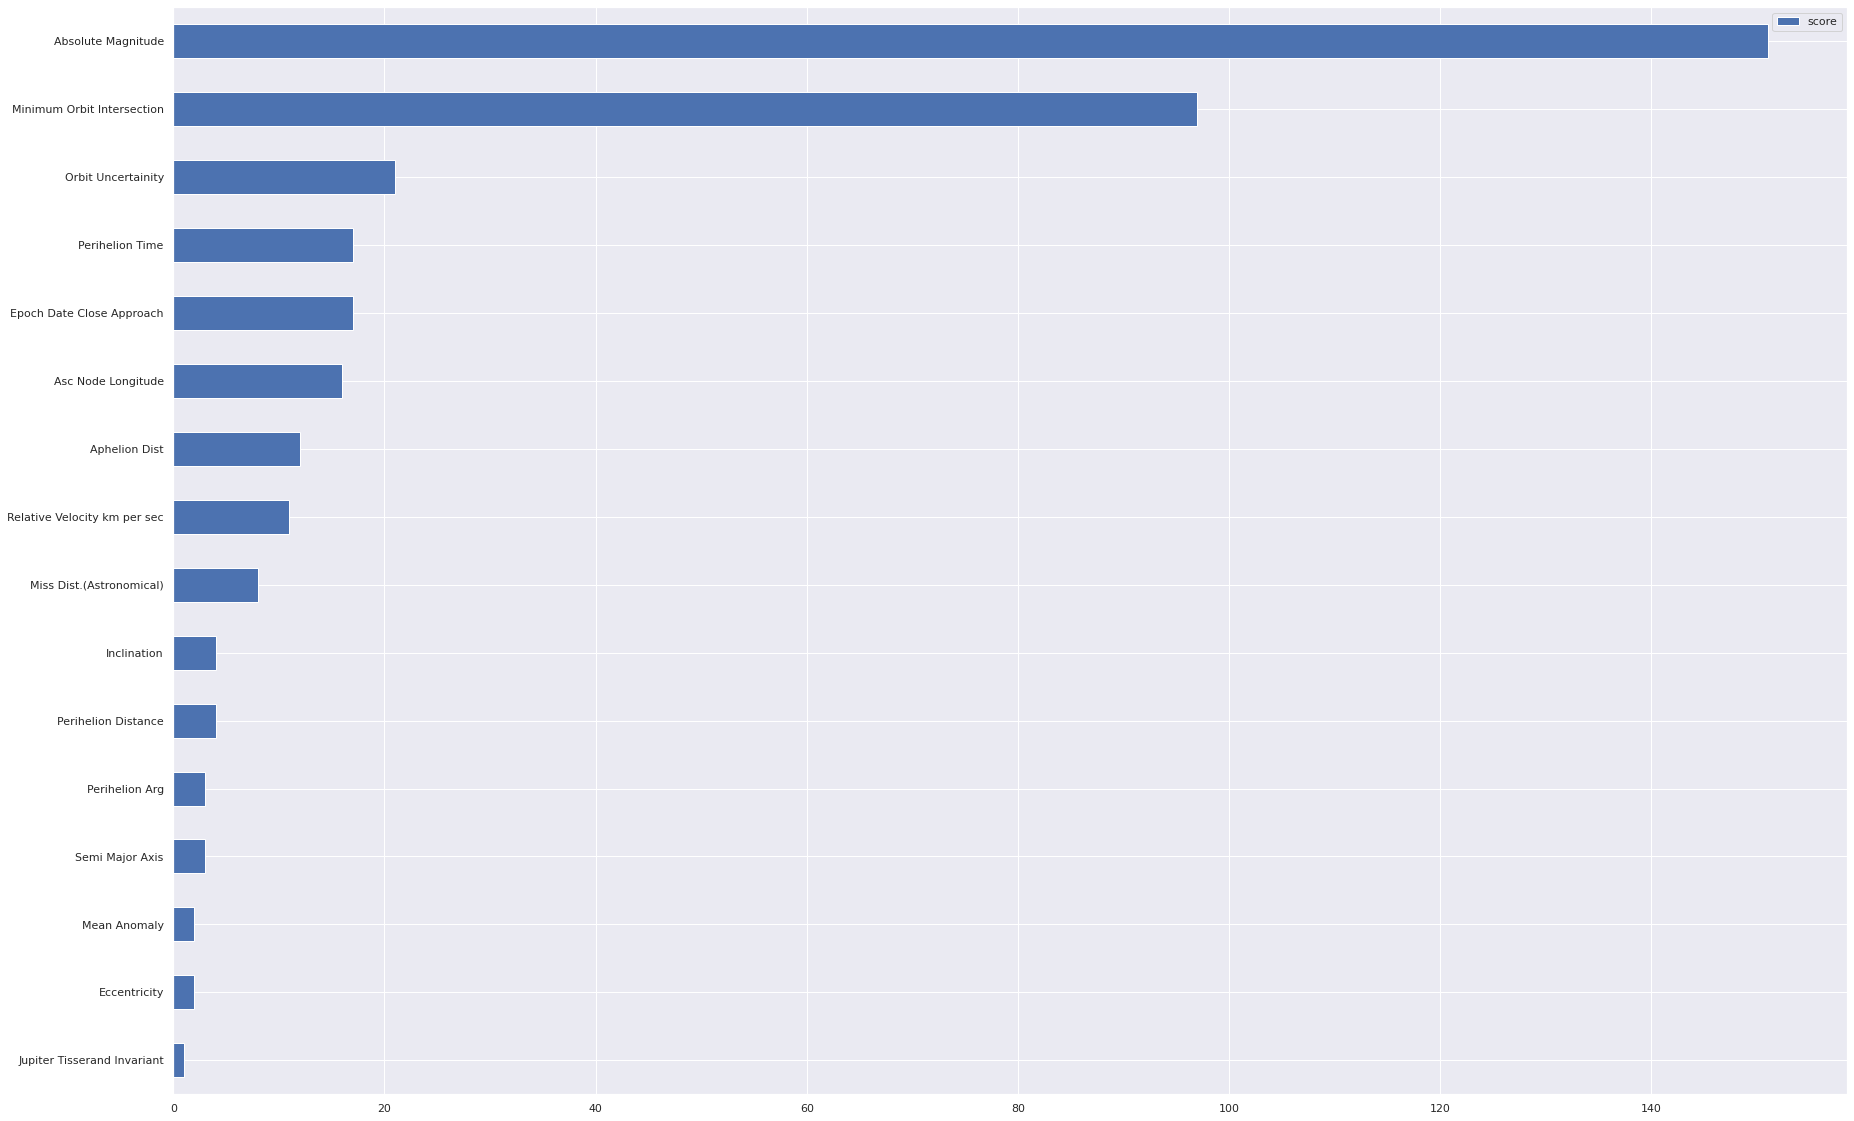

In [25]:
feature_important = xbg_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')